In [1]:
from src.classes.network import Network
from src.classes.node import Node

# help

In [2]:
# voorbeeld

num_nodes = 100
correlation = 0.5
update_fraction = 0.1
starting_distribution = 0.5     # L / R ratio (niet per se nodig maar kan misschien leuk zijn om te varieern)
p = 0.5
k = 2

network = Network(num_nodes, correlation, update_fraction, starting_distribution, p, k)

for round in range(100):
    network.update_round()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


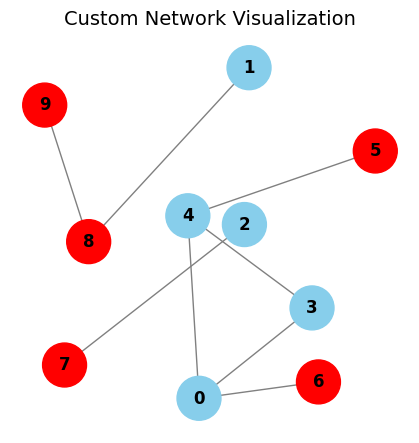

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


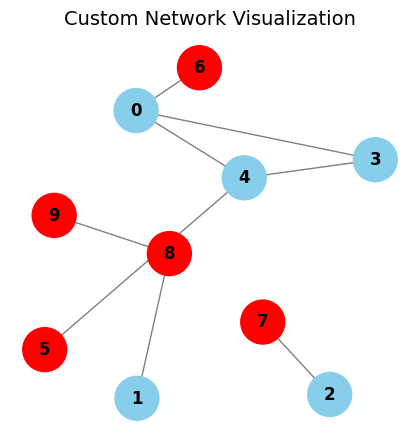

In [1]:
from src.classes.network import Network
from src.viusalization import plot_network

def create_network():
    netwerkje = Network(10, -1)
    plot_network(netwerkje)
    netwerkje.update_round()
    plot_network(netwerkje)
create_network()
